In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from util import visual_matching_2D_plot_all_mice

In [2]:
data_folder = './data/visualstim/'
save_folder = './Figures/Fig5/'
if os.path.exists(save_folder)==False:
    os.mkdir(save_folder)

# Static match

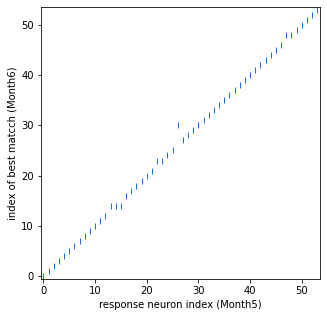

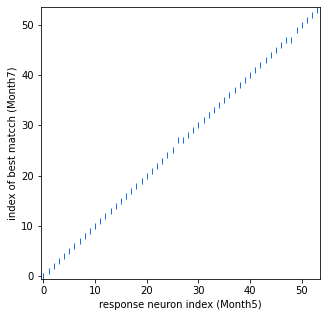

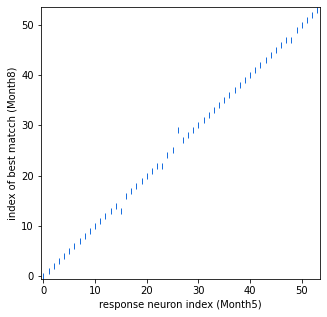

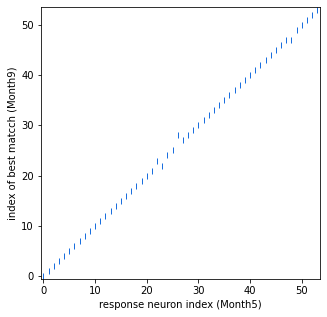

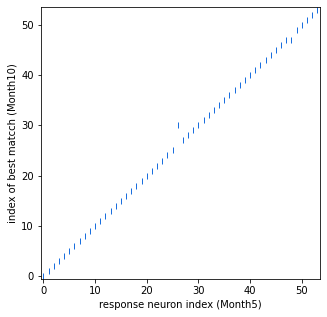

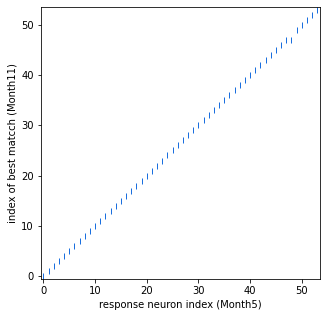

In [3]:
stimulus_type = 'Static'
mouse_ids = np.array(['mouse1','mouse2','mouse3','mouse4','mouse5'])
months = np.array(['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7'])
months_show = np.array(['Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11'])
pair_neuron_ids_all_mice = []

begin_index = 0
for mouse_id_id, mouse_id in enumerate(mouse_ids):
    pair_neuron_ids_all_day = pd.read_csv(data_folder+f'{mouse_id}_pair_neuron_ids_Static.csv')
    pair_neuron_ids_all_day = pair_neuron_ids_all_day[months] + begin_index
    pair_neuron_ids_all_day['mouse_id'] = mouse_id
    pair_neuron_ids_all_day['mouse_plot_id'] = mouse_id_id
    pair_neuron_ids_all_mice.append(pair_neuron_ids_all_day)
    begin_index = begin_index + len(pair_neuron_ids_all_day)
    
pair_neuron_ids_all_mice = pd.concat(pair_neuron_ids_all_mice)

for month1_id in range(1,len(months)):
    month1 = months[month1_id]
    month1_show = months_show[month1_id]
    pair_neuron_ids_month0 = pair_neuron_ids_all_mice[months[0]].values
    pair_neuron_ids_month1 = pair_neuron_ids_all_mice[month1].values
    mouse_plot_ids=pair_neuron_ids_all_mice['mouse_plot_id'].values
    percent = np.sum(pair_neuron_ids_month0==pair_neuron_ids_month1)/len(pair_neuron_ids_month0)
    
    save_path = save_folder + f'/Fig5e_{months_show[0]}_{month1_show}.png'
    visual_matching_2D_plot_all_mice(pair_neuron_ids_month0, pair_neuron_ids_month1, months_show[0], month1_show, 
                        shank_ids=mouse_plot_ids, color='#1A6FDF',
                                     save_path=save_path)

# Static stable percentage

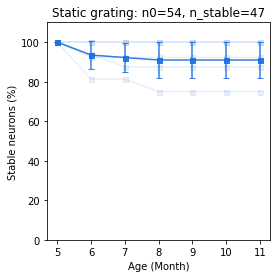

In [4]:
total_counts = []
stable_counts = []
for mouse_id in mouse_ids:
    count_df = pd.read_csv(data_folder+f'{mouse_id}_neuron_count_Static.csv')
    total_counts.append(count_df['total count'].values)
    stable_counts.append(count_df['stable count'].values)

total_counts = np.vstack(total_counts)
stable_counts = np.vstack(stable_counts)

concat_total_counts = np.sum(total_counts, axis=0)
concat_stable_counts = np.sum(stable_counts, axis=0)

stable_percent = stable_counts / np.expand_dims(stable_counts[:,0],axis=1) * 100

concat_stable_percent = np.mean(stable_percent,axis=0)
concat_stable_percent_std = np.std(stable_percent,axis=0)

# figure
fig, ax = plt.subplots(figsize=(4,4))
for idx in range(len(mouse_ids)):
    ax.plot(stable_percent[idx,:], c='#1A6FDF', marker='s', alpha=0.1, markersize=5)

ax.errorbar(range(7), concat_stable_percent, yerr=concat_stable_percent_std, 
                    c='#1A6FDF', marker='s', alpha=0.9, capsize=3, markersize=5)
ax.set_ylim([0,110])
ax.set_ylabel('Stable neurons (%)')
ax.set_xticks(np.arange(7), np.arange(7)+5)
ax.set_xlabel('Age (Month)')
ax.set_title(f'Static grating: n0={concat_stable_counts[0]}, n_stable={concat_stable_counts[-1]}')

plt.savefig(save_folder+f'Fig5f.png')

# Same cells v.s. different cells

In [5]:
months = np.array(['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7'])
months_show = np.array(['Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11'])

r_within_all_mice = []
r_diff_all_mice = []
mouse_plot_ids = []

for mouse_id_id, mouse_id in enumerate(mouse_ids):
    file = open(data_folder+f'{mouse_id}_r_within_day_Static', 'rb')
    r_within_day = pickle.load(file)
    file.close()
    file = open(data_folder+f'{mouse_id}_r_diff_day_Static', 'rb')
    r_diff_day = pickle.load(file)
    file.close()

    r_within = np.squeeze(np.array(list(r_within_day.values()))).T
    r_diff = np.vstack([np.reshape(r_diff_day[day_name],(-1,)) for day_name in months])
    
    r_within_all_mice.append(r_within)
    r_diff_all_mice.append(r_diff)
    
    mouse_plot_ids.append([mouse_id]*len(r_within))
    
r_within_all_mice = np.vstack(r_within_all_mice)
r_diff_all_mice = np.vstack([np.hstack([r_diff_all_mice[i][month_id,:] for i in range(len(mouse_ids))]) 
                             for month_id in range(len(months))]).T

mouse_plot_ids = np.hstack(mouse_plot_ids)

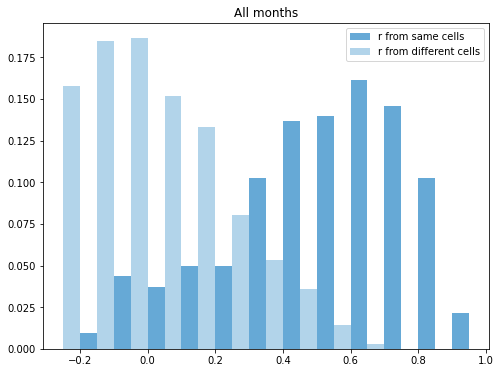

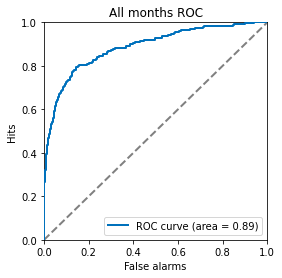

In [6]:
r_within_all_days = np.reshape(r_within_all_mice,(-1,))
r_diff_all_days = np.reshape(r_diff_all_mice,(-1,))
r_within_all_days = r_within_all_days[~np.isnan(r_within_all_days)]
r_diff_all_days = r_diff_all_days[~np.isnan(r_diff_all_days)]

fig, ax = plt.subplots(figsize=(8,6))
maxbin = 1
minbin = -0.2
binsize = 0.1
bin_counts_day1, bin_edges = np.histogram(r_within_all_days, bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line1 = ax.bar(bin_edges[:-1]+binsize/4,bin_counts_day1*binsize,width=binsize*0.5,color='#0071BC', alpha=0.6)
bin_counts_day0, bin_edges = np.histogram(r_diff_all_days, bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line2 = ax.bar(bin_edges[:-1]-binsize/4,bin_counts_day0*binsize,width=binsize*0.5,color='#0071BC', alpha=0.3)
ax.legend([line1, line2],['r from same cells', 'r from different cells'])
ax.set_title('All months')
plt.savefig(save_folder+f'Fig5g.png')

y_score  = np.hstack((r_within_all_days, r_diff_all_days))
y_true = np.hstack((np.ones(r_within_all_days.shape), np.zeros(r_diff_all_days.shape)))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(4,4))
lw = 2
plt.plot(fpr,tpr,color='#0071BC',lw=lw,zorder=10,label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False alarms")
plt.ylabel("Hits")
plt.title("All months ROC")
plt.legend(loc="lower right")
plt.savefig(save_folder+'Fig5h.png')


# Dynamic match

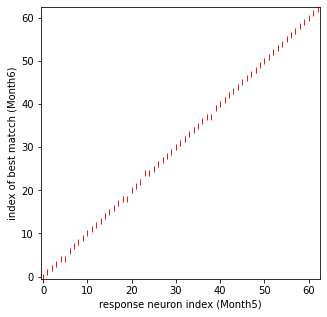

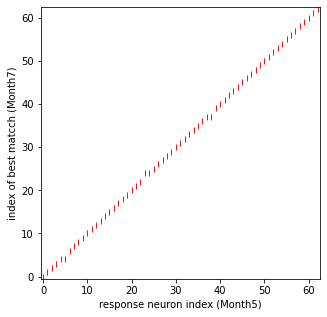

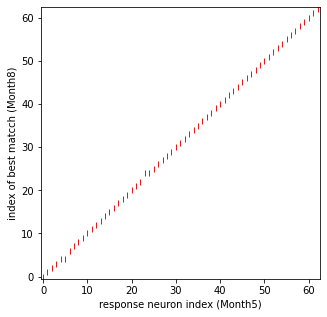

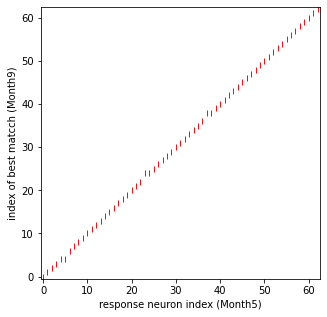

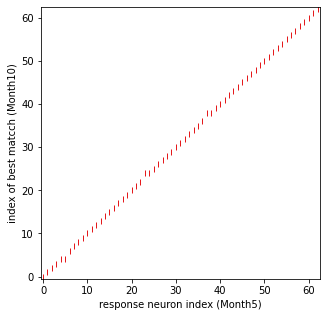

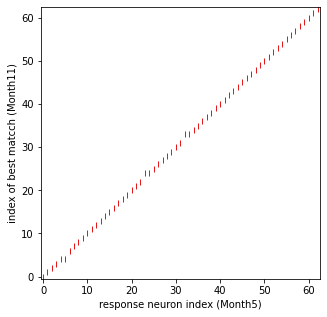

In [7]:
mouse_ids = np.array(['mouse1','mouse2','mouse3','mouse4','mouse5'])
months = np.array(['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7'])
months_show = np.array(['Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11'])
pair_neuron_ids_all_mice = []

begin_index = 0
for mouse_id_id, mouse_id in enumerate(mouse_ids):
    pair_neuron_ids_all_day = pd.read_csv(data_folder+f'{mouse_id}_pair_neuron_ids_Dynamic.csv')
    pair_neuron_ids_all_day = pair_neuron_ids_all_day[months] + begin_index
    pair_neuron_ids_all_day['mouse_id'] = mouse_id
    pair_neuron_ids_all_day['mouse_plot_id'] = mouse_id_id
    pair_neuron_ids_all_mice.append(pair_neuron_ids_all_day)
    begin_index = begin_index + len(pair_neuron_ids_all_day)
    
pair_neuron_ids_all_mice = pd.concat(pair_neuron_ids_all_mice)

for month1_id in range(1,len(months)):
    month1 = months[month1_id]
    month1_show = months_show[month1_id]
    pair_neuron_ids_month0 = pair_neuron_ids_all_mice[months[0]].values
    pair_neuron_ids_month1 = pair_neuron_ids_all_mice[month1].values
    mouse_plot_ids=pair_neuron_ids_all_mice['mouse_plot_id'].values
    percent = np.sum(pair_neuron_ids_month0==pair_neuron_ids_month1)/len(pair_neuron_ids_month0)

    save_path = save_folder + f'/Fig5k_{months_show[0]}_{month1_show}.png'
    visual_matching_2D_plot_all_mice(pair_neuron_ids_month0, pair_neuron_ids_month1, months_show[0], month1_show, 
                        shank_ids=mouse_plot_ids, color='#E51A1C',
                                     save_path=save_path)

# Dynamic stable percentage

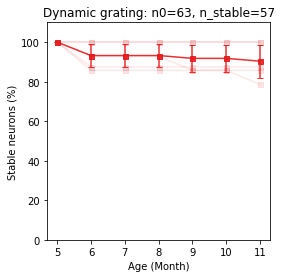

In [8]:
total_counts = []
stable_counts = []
for mouse_id in mouse_ids:
    count_df = pd.read_csv(data_folder+f'{mouse_id}_neuron_count_Dynamic.csv')
    total_counts.append(count_df['total count'].values)
    stable_counts.append(count_df['stable count'].values)

total_counts = np.vstack(total_counts)
stable_counts = np.vstack(stable_counts)

concat_total_counts = np.sum(total_counts, axis=0)
concat_stable_counts = np.sum(stable_counts, axis=0)

stable_percent = stable_counts / np.expand_dims(stable_counts[:,0],axis=1) * 100

concat_stable_percent = np.mean(stable_percent,axis=0)
concat_stable_percent_std = np.std(stable_percent,axis=0)

# figure
fig, ax = plt.subplots(figsize=(4,4))
for idx in range(len(mouse_ids)):
    ax.plot(stable_percent[idx,:], c='#E51A1C', marker='s', alpha=0.1, markersize=5)

ax.errorbar(range(7), concat_stable_percent, yerr=concat_stable_percent_std, 
                    c='#E51A1C', marker='s', alpha=0.9, capsize=3, markersize=5)
ax.set_ylim([0,110])
ax.set_ylabel('Stable neurons (%)')
ax.set_xticks(np.arange(7), np.arange(7)+5)
ax.set_xlabel('Age (Month)')
ax.set_title(f'Dynamic grating: n0={concat_stable_counts[0]}, n_stable={concat_stable_counts[-1]}')

plt.savefig(save_folder+f'Fig5l.png')

# Same cells v.s. different cells

In [9]:
months = np.array(['Month1', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7'])
months_show = np.array(['Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11'])

r_within_all_mice = []
r_diff_all_mice = []
mouse_plot_ids = []

for mouse_id_id, mouse_id in enumerate(mouse_ids):
    file = open(data_folder+f'{mouse_id}_r_within_day_Dynamic', 'rb')
    r_within_day = pickle.load(file)
    file.close()
    file = open(data_folder+f'{mouse_id}_r_diff_day_Dynamic', 'rb')
    r_diff_day = pickle.load(file)
    file.close()
    
    r_within = np.squeeze(np.array(list(r_within_day.values()))).T
    r_diff = np.vstack([np.reshape(r_diff_day[day_name],(-1,)) for day_name in months])
    
    r_within_all_mice.append(r_within)
    r_diff_all_mice.append(r_diff)
    
    mouse_plot_ids.append([mouse_id]*len(r_within))
    
r_within_all_mice = np.vstack(r_within_all_mice)
r_diff_all_mice = np.vstack([np.hstack([r_diff_all_mice[i][month_id,:] for i in range(len(mouse_ids))]) 
                             for month_id in range(len(months))]).T

mouse_plot_ids = np.hstack(mouse_plot_ids)

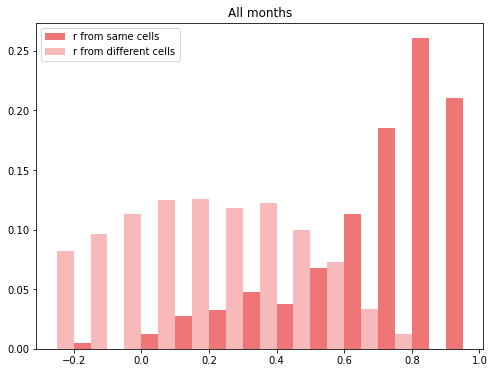

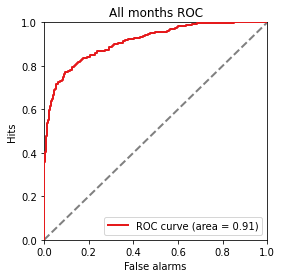

In [10]:
r_within_all_days = np.reshape(r_within_all_mice,(-1,))
r_diff_all_days = np.reshape(r_diff_all_mice,(-1,))
r_within_all_days = r_within_all_days[~np.isnan(r_within_all_days)]
r_diff_all_days = r_diff_all_days[~np.isnan(r_diff_all_days)]

fig, ax = plt.subplots(figsize=(8,6))
maxbin = 1
minbin = -0.2
binsize = 0.1
bin_counts_day1, bin_edges = np.histogram(r_within_all_days, bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line1 = ax.bar(bin_edges[:-1]+binsize/4,bin_counts_day1*binsize,width=binsize*0.5,color='#E51A1C', alpha=0.6)
bin_counts_day0, bin_edges = np.histogram(r_diff_all_days, bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line2 = ax.bar(bin_edges[:-1]-binsize/4,bin_counts_day0*binsize,width=binsize*0.5,color='#E51A1C', alpha=0.3)
ax.legend([line1, line2],['r from same cells', 'r from different cells'])
ax.set_title('All months')
plt.savefig(save_folder+f'Fig5m.png')

y_score  = np.hstack((r_within_all_days, r_diff_all_days))
y_true = np.hstack((np.ones(r_within_all_days.shape), np.zeros(r_diff_all_days.shape)))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(4,4))
lw = 2
plt.plot(fpr,tpr,color='#E51A1C',lw=lw,zorder=10,label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False alarms")
plt.ylabel("Hits")
plt.title("All months ROC")
plt.legend(loc="lower right")
plt.savefig(save_folder+'Fig5n.png')
